In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import math
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.distributions.independent import Independent
class AgentDecoder(nn.Module):
  def __init__(self, horizon, seed, bound):
    super(AgentDecoder, self).__init__()

    self.dec_rnn = nn.LSTM(6, 100, 2)
    self.dec_linear = nn.Linear(100, 10)
    self.relu = nn.LeakyReLU()
    
    # self.dec = nn.Sequential(
    #       nn.LSTM(6, 200, 2, bidirectional=True),
    #       # nn.LeakyReLU(),
    #       # nn.Linear(200, 100),
    #       # nn.LeakyReLU(),
    #       nn.Linear(200, 10),
    #       nn.LeakyReLU(),
    #   )
      
    self.decoder_mu = nn.Linear(10, 2)
    self.decoder_log_sigma = nn.Linear(10, 2)

  def decoder(self, decoder_input_n):
    h, _ = self.dec_rnn(decoder_input_n)
    h = self.relu(self.dec_linear(h))
    # h = self.dec(decoder_input_n)
    mu = self.decoder_mu(h)
    log_sigma = self.decoder_log_sigma(h)
    return mu, log_sigma
  
  def decoderLosses(self, log_decoder):
    
    decoder_loss = -torch.mean(log_decoder)
    return  decoder_loss 

  def forward(self, decoder_input_n, source_action):
    decoder_mu, decoder_log_sigma = self.decoder(decoder_input_n)
    decoder_dist = Independent(Normal(decoder_mu, torch.exp(decoder_log_sigma)), 1)
    log_decoder = decoder_dist.log_prob(source_action)
    return decoder_mu, decoder_log_sigma, log_decoder

class AgentEmp(nn.Module):
  def __init__(self, horizon, seed, bound):
    super(AgentEmp, self).__init__()
    self.emp_rnn = nn.LSTM(2, 50, 2)
    self.emp_l1 = nn.Linear(50, 100)
    self.emp_l2 = nn.Linear(100, 1)
    self.relu = nn.LeakyReLU()

    # self.critic = nn.Sequential(
    #         nn.LSTM(2, 300, 2, bidirectional=True),
    #         # nn.LeakyReLU(),
    #         # nn.Dropout(p=0.25),
    #         # nn.Linear(300, 100),
    #         # nn.LeakyReLU(),
    #         # nn.Dropout(p=0.25),
    #         nn.Linear(100, 1),
    #         nn.LeakyReLU(),
    #     )
  
  def forward(self, current_state):
      h, _ = self.emp_rnn(current_state)
      h = self.relu(self.emp_l1(h))
      return self.emp_l2(h)


class AgentSource(nn.Module):
    def __init__(self, horizon, seed, bound):
        super(AgentSource, self).__init__()
        
        self.initializer = nn.init.xavier_normal_
       
        # self.src = nn.Sequential(
        #     nn.LSTM(4, 200, 2, bidirectional=True),
        #     # nn.LeakyReLU(),
        #     # nn.Dropout(p=0.25),
        #     # nn.Linear(200, 200),
        #     # nn.LeakyReLU(),
        #     # nn.Dropout(p=0.25),
        #     nn.Linear(200, 10),
        #     nn.LeakyReLU(),
        # )
        self.agent_rnn = nn.LSTM(4, 100, 2)
        self.agent_linear = nn.Linear(100, 10)
        self.relu = nn.LeakyReLU()
        
        self.src_mu = nn.Linear(10, 2)
        self.src_log_sigma = nn.Linear(10, 2)
    
    def source(self, source_input_n):
        h,_ = self.agent_rnn(source_input_n)
        h = self.relu(self.agent_linear(h))
        log_sigma = self.src_log_sigma(h)
        mu = self.src_mu(h)
        return mu, log_sigma
    
    def sourceDistribution(self, source_action, src_mu, src_log_sigma):
      
      src_dist = Independent(Normal(src_mu, torch.exp(src_log_sigma)), 1)
      log_src = src_dist.log_prob(source_action)
      return log_src
        
    def forward(self, source_input_n):
      src_mu, src_log_sigma = self.source(source_input_n)
      return src_log_sigma, src_mu

    def squaredLoss(self, beta, log_decoder, source_action, source_input_n, emp):
        src_mu, src_log_sigma = self.forward(source_input_n)
        log_src = self.sourceDistribution(source_action, src_mu, src_log_sigma)
        # print(src_mu, src_log_sigma, log_src)
        squared_loss = torch.mean(torch.square(beta * log_decoder - emp - log_src))
        return  squared_loss


In [9]:

import numpy as np

class square_env:
    def __init__(self,duration,radius,dimension):
        self.R = radius
        self.agent_dim = radius 
        self.dimension = dimension 
        self.eps = radius/100
        self.lower_limit, self.upper_limit = self.agent_dim+self.eps, self.dimension-self.agent_dim-self.eps
        print(self.lower_limit, self.upper_limit)
        self.iter = 0
        self.duration = duration 
        self.state_seq = np.zeros((self.duration,2))
        self.obstacles = np.array([[xObst, 1] for xObst in range(1, 6)])
                
    def random_initialisation(self):
            
        self.state_seq[self.iter][0] = np.random.uniform(self.lower_limit, self.upper_limit)
        self.state_seq[self.iter][1] = np.random.uniform(self.lower_limit, self.upper_limit)
        
        self.iter = 1
        
    def boundary_conditions(self):
        
        cond_X = not (self.state_seq[self.iter][0] >= self.lower_limit)*(self.state_seq[self.iter][0] <= self.upper_limit)
        cond_Y = not (self.state_seq[self.iter][1] >= self.lower_limit)*(self.state_seq[self.iter][1] <= self.upper_limit)
        if cond_X*cond_Y:
          return cond_X*cond_Y
        
        obs = bool(( True if int(self.state_seq[self.iter][0]) in self.obstacles[:,0] else False)*( True if int(self.state_seq[self.iter][1]) in self.obstacles[:,1] else False))
        # print(obs, cond_X*cond_Y)
        return obs
            
    def step(self, action):
                
        self.state_seq[self.iter] = self.state_seq[self.iter-1] + action
        if self.boundary_conditions():
            self.state_seq[self.iter] -= action
        # print(self.state_seq[self.iter], self.state_seq[self.iter-1], action)           
        self.iter += 1
        if self.iter > self.duration:
            raise Exception("Game over!") 
            
    def env_response(self,actions,horizon):
        for i in range(1,horizon):
            self.step(actions[i])
        # print(self.state_seq)
        
    def reset(self):
        self.state_seq = np.zeros((self.duration,2))
        self.iter = 0
        

In [10]:
!mkdir plots

mkdir: cannot create directory ‘plots’: File exists


In [11]:
!mkdir weights

mkdir: cannot create directory ‘weights’: File exists


In [14]:
import seaborn as sns

def heatmap(emp,env,num_image, res=1):
    plt.clf()
    
    R, D = env.R, env.dimension
    xy = np.mgrid[R:int(D)-R:res, R:int(D)-R:res].reshape(2,-1).T
    L = int((D-2*R)/res)

    mu = env.dimension/2.0 - R 
    sigma = ((2*mu)**2)/12
    xy_ = (xy - mu)/sigma
    
    values = emp(torch.FloatTensor(xy_)).detach().numpy()
    
    val = values.reshape(L,L)
    sns.heatmap(val[1:L,1:L],xticklabels=False,\
                yticklabels=False,cmap="YlGnBu", cbar=False)
    plt.savefig("plots/" + str(num_image)+".png")

0.0 10.0
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500


KeyboardInterrupt: ignored

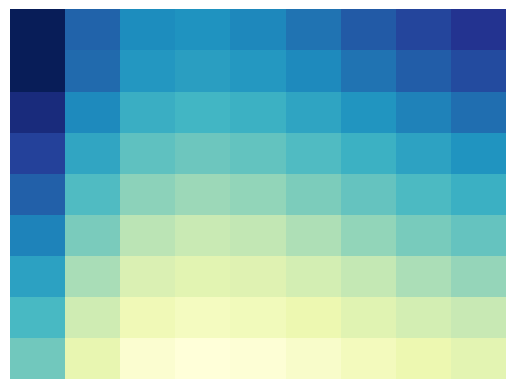

In [15]:

import matplotlib.pyplot as plt
import numpy as np
import copy

# define training parameters:
horizon = 2
seed = 42
bound = 0.5
iters = 100000
batch_size = 200
lr = 0.01
R = 0.0

# define environment:
env = square_env(duration=horizon,radius=R,dimension=10)

ADec = AgentDecoder(horizon,seed,bound)
ASrc = AgentSource(horizon,seed,bound)
AEmp = AgentEmp(horizon,seed,bound)
decoder_optimizer = optim.Adagrad(ADec.parameters(), lr=0.01)
# src_slow_optimizer = optim.Adagrad(ASrc.parameters() , lr=0.0005)
src_slow_optimizer = optim.Adagrad([
                {'params': ASrc.parameters()},
                {'params': AEmp.parameters(), 'lr': 5e-3}
            ], lr=5e-3)

loss_src = []
loss_dec = []
def main():
    # betas = 
    beta = 1e-2
    ## define inverse probability:
    inverse_prob = 1./np.array([min(0.01 + i/iters,1) for i in range(iters)])

    ### initialise the variables:
    # sess.run(A.init_g)

    for count in range(iters):
        env.reset()
        env.random_initialisation()

        mini_batch = np.zeros((batch_size*horizon,6))
        action_batch = np.zeros((batch_size*horizon,2))
        
        mu = env.dimension/2.0 - R 
        sigma = ((2*mu)**2)/12 
        for i in range(batch_size):

            env.iter = 0

            if np.random.rand() > 1/inverse_prob[count]:
                actions = np.random.normal(0,bound,size = (horizon,2))

                # net_actions = np.cumsum(actions,0)

            else:
                state = (env.state_seq[env.iter]-mu)/sigma
                actions = np.zeros((horizon,2))

                # net_actions = np.zeros((horizon,2))

                for i in range(1,horizon):

                    AS_n = np.concatenate((actions[i-1],state))
                    with torch.no_grad():
                      src_log_sigma, src_mu = ASrc(torch.FloatTensor(AS_n.reshape((1,4))))
                    actions[i] = np.random.normal(src_mu.clone().detach().numpy(),np.exp(src_log_sigma.clone().detach().numpy())) 
                      # net_actions[i] = actions[i] + net_actions[i-1]
                
            # print(actions)
            env.iter += 1 
            env.env_response(actions,horizon)

            ss_ = np.concatenate((env.state_seq[env.iter-horizon],env.state_seq[env.iter-1])).reshape((1,4))
            S = np.repeat(ss_,horizon,axis=0)
            # print("S", S, env.state_seq, env.iter-horizon, env.iter-1, env.iter)
            # print("action", actions)
        
            axx_ =  np.concatenate((actions,S),axis=1)

            mini_batch[horizon*i:horizon*(i+1)] = axx_
            action_batch[horizon*i:horizon*(i+1)] = actions
            # print("mini_batch[horizon*i:horizon*(i+1)]", mini_batch[horizon*i:horizon*(i+1)])

        mini_batch[:,2:6] = (mini_batch[:,2:6] - mu)/sigma
       
        decoder_mu, decoder_log_sigma, log_decoder = ADec(torch.FloatTensor(mini_batch), torch.FloatTensor(action_batch))
        
        decoderLoss = ADec.decoderLosses(log_decoder)
        log_decoder_clone = copy.deepcopy(log_decoder.clone().detach().numpy())
        decoderLoss_plot = copy.deepcopy(decoderLoss.clone().detach().numpy())
        loss_dec.append(decoderLoss_plot)

        # print(ADec.decoder_mu.weight.data.numpy())
        # if count % 500 == 0:
        #   print("Decoder mu", ADec.decoder_mu.weight.data.numpy())
        #   print("Decoder sigma", ADec.decoder_log_sigma.weight.data.numpy())
        #   print("Source mu", ASrc.src_mu.weight.data.numpy())
        #   print("Source sigma", ASrc.src_log_sigma.weight.data.numpy())

          # plot_kernels(ADec.decoder_mu.weight.data.numpy())
          # plot_kernels(ASrc.src_mu.weight.data.numpy())

        
        decoder_optimizer.zero_grad()
        decoderLoss.backward()
        decoder_optimizer.step()

        emp = AEmp(torch.FloatTensor(mini_batch[:,2:4]))
        src_slow_optimizer.zero_grad()
        
        squaredLoss = ASrc.squaredLoss(beta, torch.FloatTensor(log_decoder_clone), torch.FloatTensor(action_batch), torch.FloatTensor(mini_batch[:,0:4]), emp)
        squaredLoss_plot = copy.deepcopy(squaredLoss.clone().detach().numpy())
        loss_src.append(squaredLoss_plot)

        squaredLoss.backward()
        src_slow_optimizer.step()
        if count % 500 == 0:
            print(count)
            heatmap(AEmp,env,count)

main()


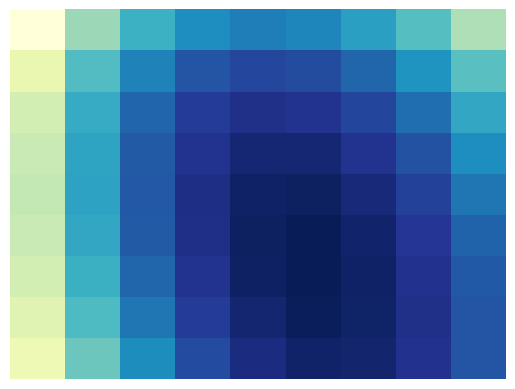

In [21]:
heatmap(AEmp,env,"count")


In [ ]:
def plot_kernels(tensor, num_cols=2):
    plt.clf()
    # if not tensor.ndim==4:
    #     raise Exception("assumes a 4D tensor")
    # if not tensor.shape[-1]==3:
    #     raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    # fig = plt.figure(figsize=(num_cols,num_rows))
    # for i in range(tensor.shape[0]):
    #     ax1 = fig.add_subplot(num_rows,num_cols,i+1)
    #     ax1.imshow(tensor[i])
    #     ax1.axis('off')
    #     ax1.set_xticklabels([])
    #     ax1.set_yticklabels([])

    # plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.imshow(tensor)
    plt.show()
    
    


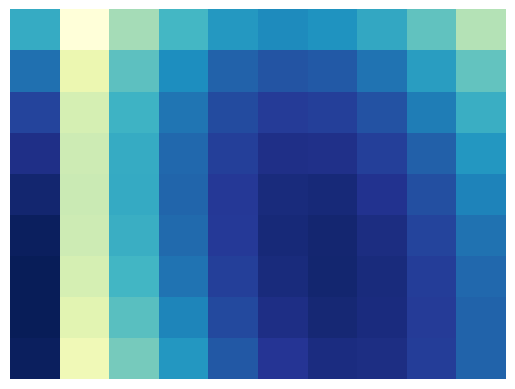

In [12]:
# import seaborn as sns

def heatmap(emp,env,num_image, res=1):
    plt.clf()
    
    R, D = env.R, env.dimension
    xy = np.mgrid[R:int(D)-R:res, R:int(D)-R:res].reshape(2,-1).T
    L = int((D-2*R)/res)
    # print(xy)

    mu = env.dimension/2.0 - R 
    sigma = ((2*mu)**2)/12
    xy_ = (xy - mu)/sigma
    
    values = emp(torch.FloatTensor(xy_)).detach().numpy()
    # print(values)
    # print(np.concatenate((xy,values),axis=1))
    val = values.reshape(L,L)
    sns.heatmap(val[1:L,0:L],xticklabels=False,
                yticklabels=False,cmap="YlGnBu", cbar=False)
    plt.savefig("plots/" + str(num_image)+".png")

heatmap(AEmp,env,1111)


In [ ]:
plt.plot(loss_src)

In [ ]:
loss_src

[array(3.736157, dtype=float32),
 array(1.3269571, dtype=float32),
 array(0.50595045, dtype=float32),
 array(0.13547792, dtype=float32),
 array(0.29599196, dtype=float32),
 array(0.21155982, dtype=float32),
 array(0.27840063, dtype=float32),
 array(0.19799067, dtype=float32),
 array(0.2689977, dtype=float32),
 array(0.17870334, dtype=float32),
 array(0.14875884, dtype=float32),
 array(0.14706323, dtype=float32),
 array(0.15340285, dtype=float32),
 array(0.1472227, dtype=float32),
 array(0.19778587, dtype=float32),
 array(0.15192974, dtype=float32),
 array(0.2326749, dtype=float32),
 array(0.22082251, dtype=float32),
 array(0.14287493, dtype=float32),
 array(0.15957692, dtype=float32),
 array(0.11766033, dtype=float32),
 array(0.1420254, dtype=float32),
 array(0.16193388, dtype=float32),
 array(0.19699532, dtype=float32),
 array(0.1614976, dtype=float32),
 array(0.19672929, dtype=float32),
 array(0.16332936, dtype=float32),
 array(0.09642608, dtype=float32),
 array(0.14890385, dtype=flo

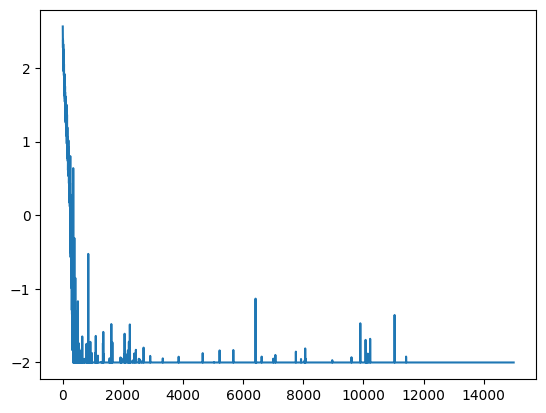

In [ ]:
plt.plot(loss_dec)

In [13]:
!zip plotsfinal.zip plots/*

  adding: plots/0.png (deflated 71%)
  adding: plots/10000.png (deflated 71%)
  adding: plots/1000.png (deflated 73%)
  adding: plots/10500.png (deflated 70%)
  adding: plots/11000.png (deflated 71%)
  adding: plots/11500.png (deflated 70%)
  adding: plots/12000.png (deflated 71%)
  adding: plots/12500.png (deflated 70%)
  adding: plots/13000.png (deflated 71%)
  adding: plots/13500.png (deflated 70%)
  adding: plots/14000.png (deflated 70%)
  adding: plots/14500.png (deflated 71%)
  adding: plots/15000.png (deflated 70%)
  adding: plots/1500.png (deflated 72%)
  adding: plots/15500.png (deflated 71%)
  adding: plots/16000.png (deflated 71%)
  adding: plots/16500.png (deflated 70%)
  adding: plots/17000.png (deflated 70%)
  adding: plots/17500.png (deflated 70%)
  adding: plots/18000.png (deflated 70%)
  adding: plots/18500.png (deflated 71%)
  adding: plots/19000.png (deflated 70%)
  adding: plots/19500.png (deflated 72%)
  adding: plots/20000.png (deflated 71%)
  adding: plots/2000.p

In [ ]:
not False

True

In [ ]:
for i in range(1,1):
  print(i)

In [ ]:
[[4, xObst] for xObst in range(1, 4)] + [[7, xObst] for xObst in range(1, 7)]

[[4, 1], [4, 2], [4, 3], [7, 1], [7, 2], [7, 3], [7, 4], [7, 5], [7, 6]]